## Import Dependencies

In [20]:
import pathlib
import sys
import typing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
# sns.set_style('white')

In [21]:
# paths initialization
data_dir = Path('/home/adel/projects/caid2-reference/data/')
reference_dir = data_dir / 'references'
disprot_dir = data_dir / 'disprot'
json_dir = data_dir / 'json'
predictions_dir = data_dir / 'predictions'

## Parsers

In [3]:
from itertools import groupby
class Reference:
    def __init__(self, file_path: str = None, ref_type=None, name=''):
        file_path = Path(file_path)
        self.file = open(file_path, 'r')
        if ref_type is None:
            self.type = 'binding' if 'binding' in file_path.stem else 'disorder'
        else:
            self.type = ref_type
        self.name = file_path.stem if name is '' else name

    def __str__(self):
        return self.name

    def __del__(self):
        self.file.close()

    def vectorized_format(self):
        output = {}
        for line in self.file:
            if line.startswith('>'):
                # remove line return and accession '>'
                acc = line.strip('>\n')
                # output[acc] = (next(self.file).strip('\n'), next(self.file).strip('\n'))
                output[acc] = (next(self.file).strip('\n'), next(self.file).strip('\n'))
                yield  acc, *output[acc]
        return output

    def to_dataframe(self):
        df = pd.DataFrame(columns=['sequence', 'state'])
        for line in self.file:
            if line.startswith('>'):
                # remove line return and accession '>'
                acc = line.strip('>\n')
                df.loc[acc] = [next(self.file).strip('\n'), next(self.file).strip('\n')]
        return df

    def states_counts(self):
        state_count = {
            self.type: 0,
            'structure': 0,
            'undefined': 0
        }
        for line in self.file:
            if not line.startswith('>'):
                state_count[self.type] += line.count('1')
                state_count['structure'] += line.count('0')
                state_count['undefined'] += line.count('-')
        return state_count







<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_150181/3358053801.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.name = file_path.stem if name is '' else name


## Number of residues for each class in different references

,disorder,binding,structure,undefined
binding,0,8449,76990,0
protein_binding,0,6535,56825,0
linker,2040,0,38532,0
pdb-disorder-atleast,4561,0,94213,198672
nucleic_acid_binding,0,398,7393,0
disorder,34163,0,261667,0


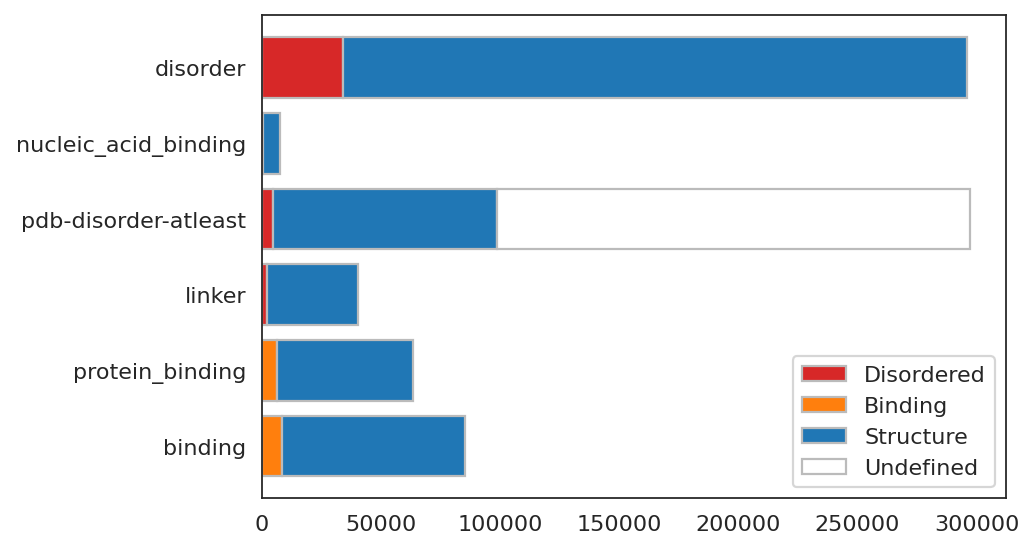

In [22]:
ref_df = pd.DataFrame(columns=['disorder', 'binding', 'structure', 'undefined'])
names = []
for reference in reference_dir.glob('*'):
    # reference = Path('/home/adel/projects/caid2-reference/data/references/disorder.fasta')
    # with open(reference, 'r') as f:
    ref_type = 'binding' if 'binding' in reference.stem else 'disorder'
    ref = Reference(reference.resolve(), ref_type=ref_type, name=reference.stem)
    counts = ref.states_counts()

    line = pd.DataFrame(counts, index=[ref.name])
    ref_df = pd.concat([ref_df, line])

fig, ax = plt.subplots()

ref_df = ref_df.fillna(0)
# plot the horizontal bars
disorder_bar = ax.barh(ref_df.index, ref_df['disorder'], left=None, color='#D72828', edgecolor='#BBB')
binding_bar = ax.barh(ref_df.index, ref_df['binding'], left=ref_df['disorder'], color='#FF7F0D', edgecolor='#BBB')
structure_bar = ax.barh(ref_df.index, ref_df['structure'], left=ref_df['binding'] + ref_df['disorder'], color='#2077B5', edgecolor='#BBB') # we add the 'left' starting point of the bars
undefined_bar = ax.barh(ref_df.index, ref_df['undefined'], left=ref_df['structure'] + ref_df['binding'] + ref_df['disorder'], color='#ffff', edgecolor='#BBB')

# set edge_width to 0 for the undefined_bar elements that have a zero width
for bar_type in [disorder_bar, binding_bar, structure_bar, undefined_bar]:
    zero_width_rect = filter(lambda rect: rect.get_width() == 0, bar_type.get_children())
    for rect in zero_width_rect:
        rect.remove()


fig.dpi = 160
ax.legend([disorder_bar, binding_bar, structure_bar, undefined_bar], ["Disordered", "Binding", 'Structure', 'Undefined'], loc=0)
fig.get_figure()

# df['ones']
ref_df

## Venn Diagram
Number of proteins for each set of annotations that they contain

##

In [5]:
def make_subsets(a: set[str], b: set[str], c: set[str]):
    return (
        len(a.difference(b, c)),
        len(b.difference(a, c)),
        len(a.intersection(b).difference(c)),
        len(c.difference(a, b)),
        len(a.intersection(c).difference(b)),
        len(b.intersection(c).difference(a)),
        len(b.intersection(c, a))
    )

/home/adel/projects/caid2-reference/venv/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


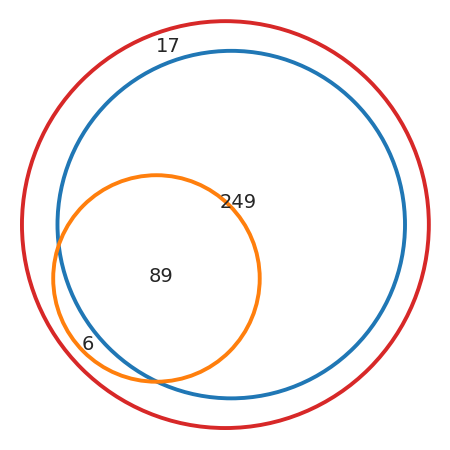

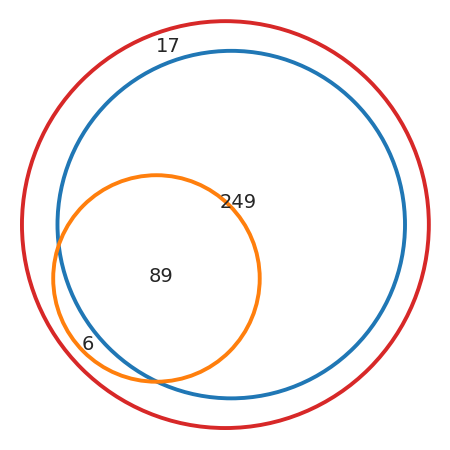

In [6]:
from venn import venn
from matplotlib_venn import venn3, venn3_circles
sets = {
    'disorder': set(),
    'binding': set(),
    'structure': set(),
}
for reference in reference_dir.glob('*'):
    # reference = Path('/home/adel/projects/caid2-reference/data/references/disorder.fasta')
    ref = Reference(reference, name=reference.stem.strip('fasta'))
    for acc, _, annotation in ref.vectorized_format():
        if '1' in annotation:
            sets[ref.type].add(acc)
        if '0' in annotation:
            sets['structure'].add(acc)

dis_set = sets['disorder']
bind_set = sets['binding']
struct_set = sets['structure']

fig, ax = plt.subplots()
subsets=make_subsets(sets['disorder'], sets['structure'], sets['binding'] )

venn_obj = venn3(subsets=subsets, ax=ax, set_labels=('', '', ''), set_colors=('#fff', '#fff', '#fff'))
# extracting each portion of the image (called patch is each circle or circle-intersection)
for patch in venn_obj.patches:
    # some patches in the list might be None
    if patch is not None:
        # set the facecolor to none, otherwise overriden by the
        patch.set_facecolor('none')
circles = venn3_circles(subsets=subsets)

circles[0].set_edgecolor('#D72828')

circles[1].set_edgecolor('#2077B5')
circles[2].set_edgecolor('#FF7F0D')

# tweaking
# making the circle bigger
circles[0].set_width(circles[0].get_width() + 0.15)
circles[0].set_height(circles[0].get_height() + 0.15)
# moving the last circle slightly lower
circles[2].set_width(circles[2].get_width() + 0.07)
circles[2].set_height(circles[2].get_height() + 0.07)
# tweaking the position of the text
for child  in ax.get_children():
    if isinstance(child, matplotlib.text.Text):
        # positioning the 17 slightly higher
        if child.get_text() == '17':
            plt.setp(child, y=child.get_position()[1] + 0.1)
        # positioning the 6 slightly lower
        if child.get_text() == '6':
            plt.setp(child, y=child.get_position()[1] - 0.05)


fig.dpi = 140
fig.get_figure()

## pie chart Number of proteins in each taxon

In [7]:
# for reference in reference_dir.glob('*'):
import requests
reference = Path('/home/adel/projects/caid2-reference/data/references/disorder.fasta')
ref = Reference(reference, name=reference.stem.strip('fasta'))
# for acc, _, _ in ref.vectorized_format():


## The distribution of the number of positive and negative residues by sequences

In [8]:
# reference = Path('/home/adel/projects/caid2-reference/data/references/disorder.fasta')
# df = pd.DataFrame(columns=['positive_average', 'negative_average'])
df = pd.DataFrame(columns=['accession', 'ref', 'type', 'positive', 'negative'])
ref_list = []
for reference in reference_dir.glob('*'):
    ref = Reference(reference, name=reference.stem.strip('fasta'))
    ref_list.append(ref.name)
    for acc, _, values in ref.vectorized_format():
        positives, negatives = values.count('1'), values.count('0')

        df.loc[len(df) + 1] = [acc, ref.name, ref.type, positives, negatives]
    # distributions[ref.name] = ref_df
    # print( ref_df['positives'].mean(), ref_df['negatives'].mean())
    # df.loc[ref.name] = [ref_df['positives'].mean(), ref_df['negatives'].mean()]

In [9]:
df[df.ref == 'binding']

,accession,ref,type,positive,negative
1,DP02342,binding,binding,24,203
2,DP02348,binding,binding,30,385
3,DP02354,binding,binding,14,324
4,DP02401,binding,binding,19,1647
5,DP02411,binding,binding,169,594
...,...,...,...,...,...
91,DP03707,binding,binding,42,345
92,DP03708,binding,binding,86,480
93,DP03709,binding,binding,214,361
94,DP03739,binding,binding,126,301


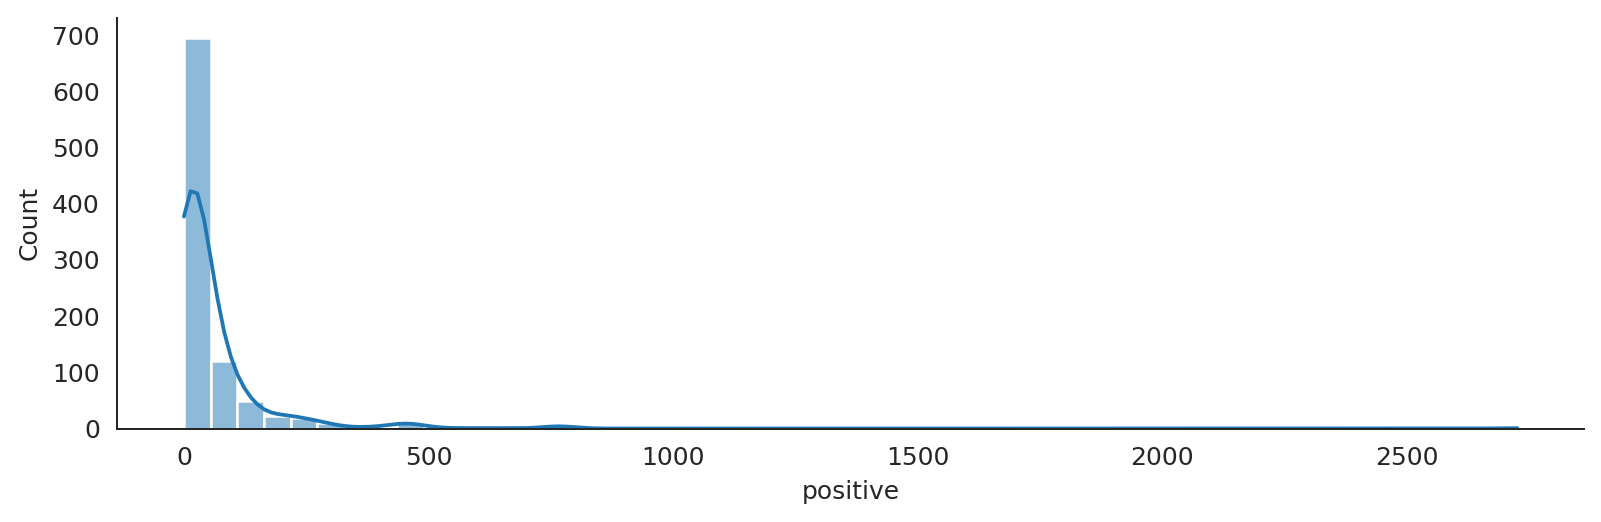

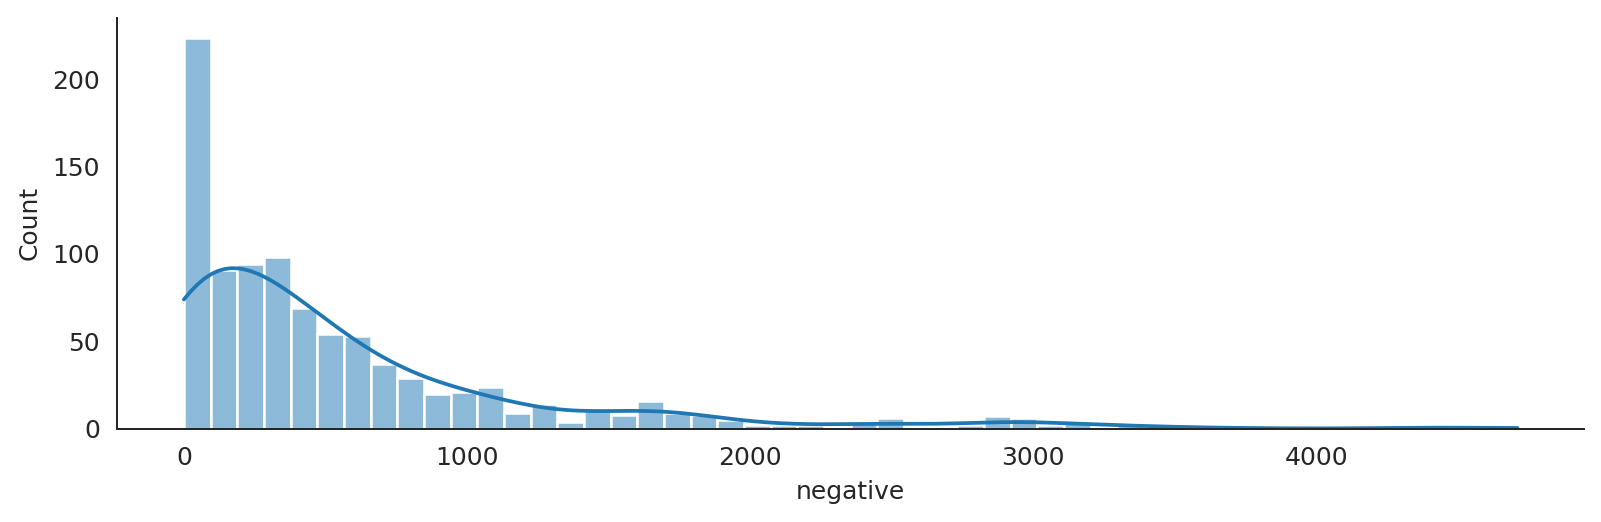

In [10]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 180

# fig = matplotlib.pyplot.figure()

# sns.displot(df, x='positive', row='ref', hue='type', bins=50, kde=True, height=3, aspect=3)
# sns.displot(df, x='negative', row='ref', hue='type', bins=50, kde=True, height=3, aspect=3)
sns.displot(df['positive'], bins=50, kde=True, height=3, aspect=3)
sns.displot(df['negative'], bins=50, kde=True, height=3, aspect=3)
# ax.set(xlabel= None)
# ax.set(ylabel= 'occurrences')


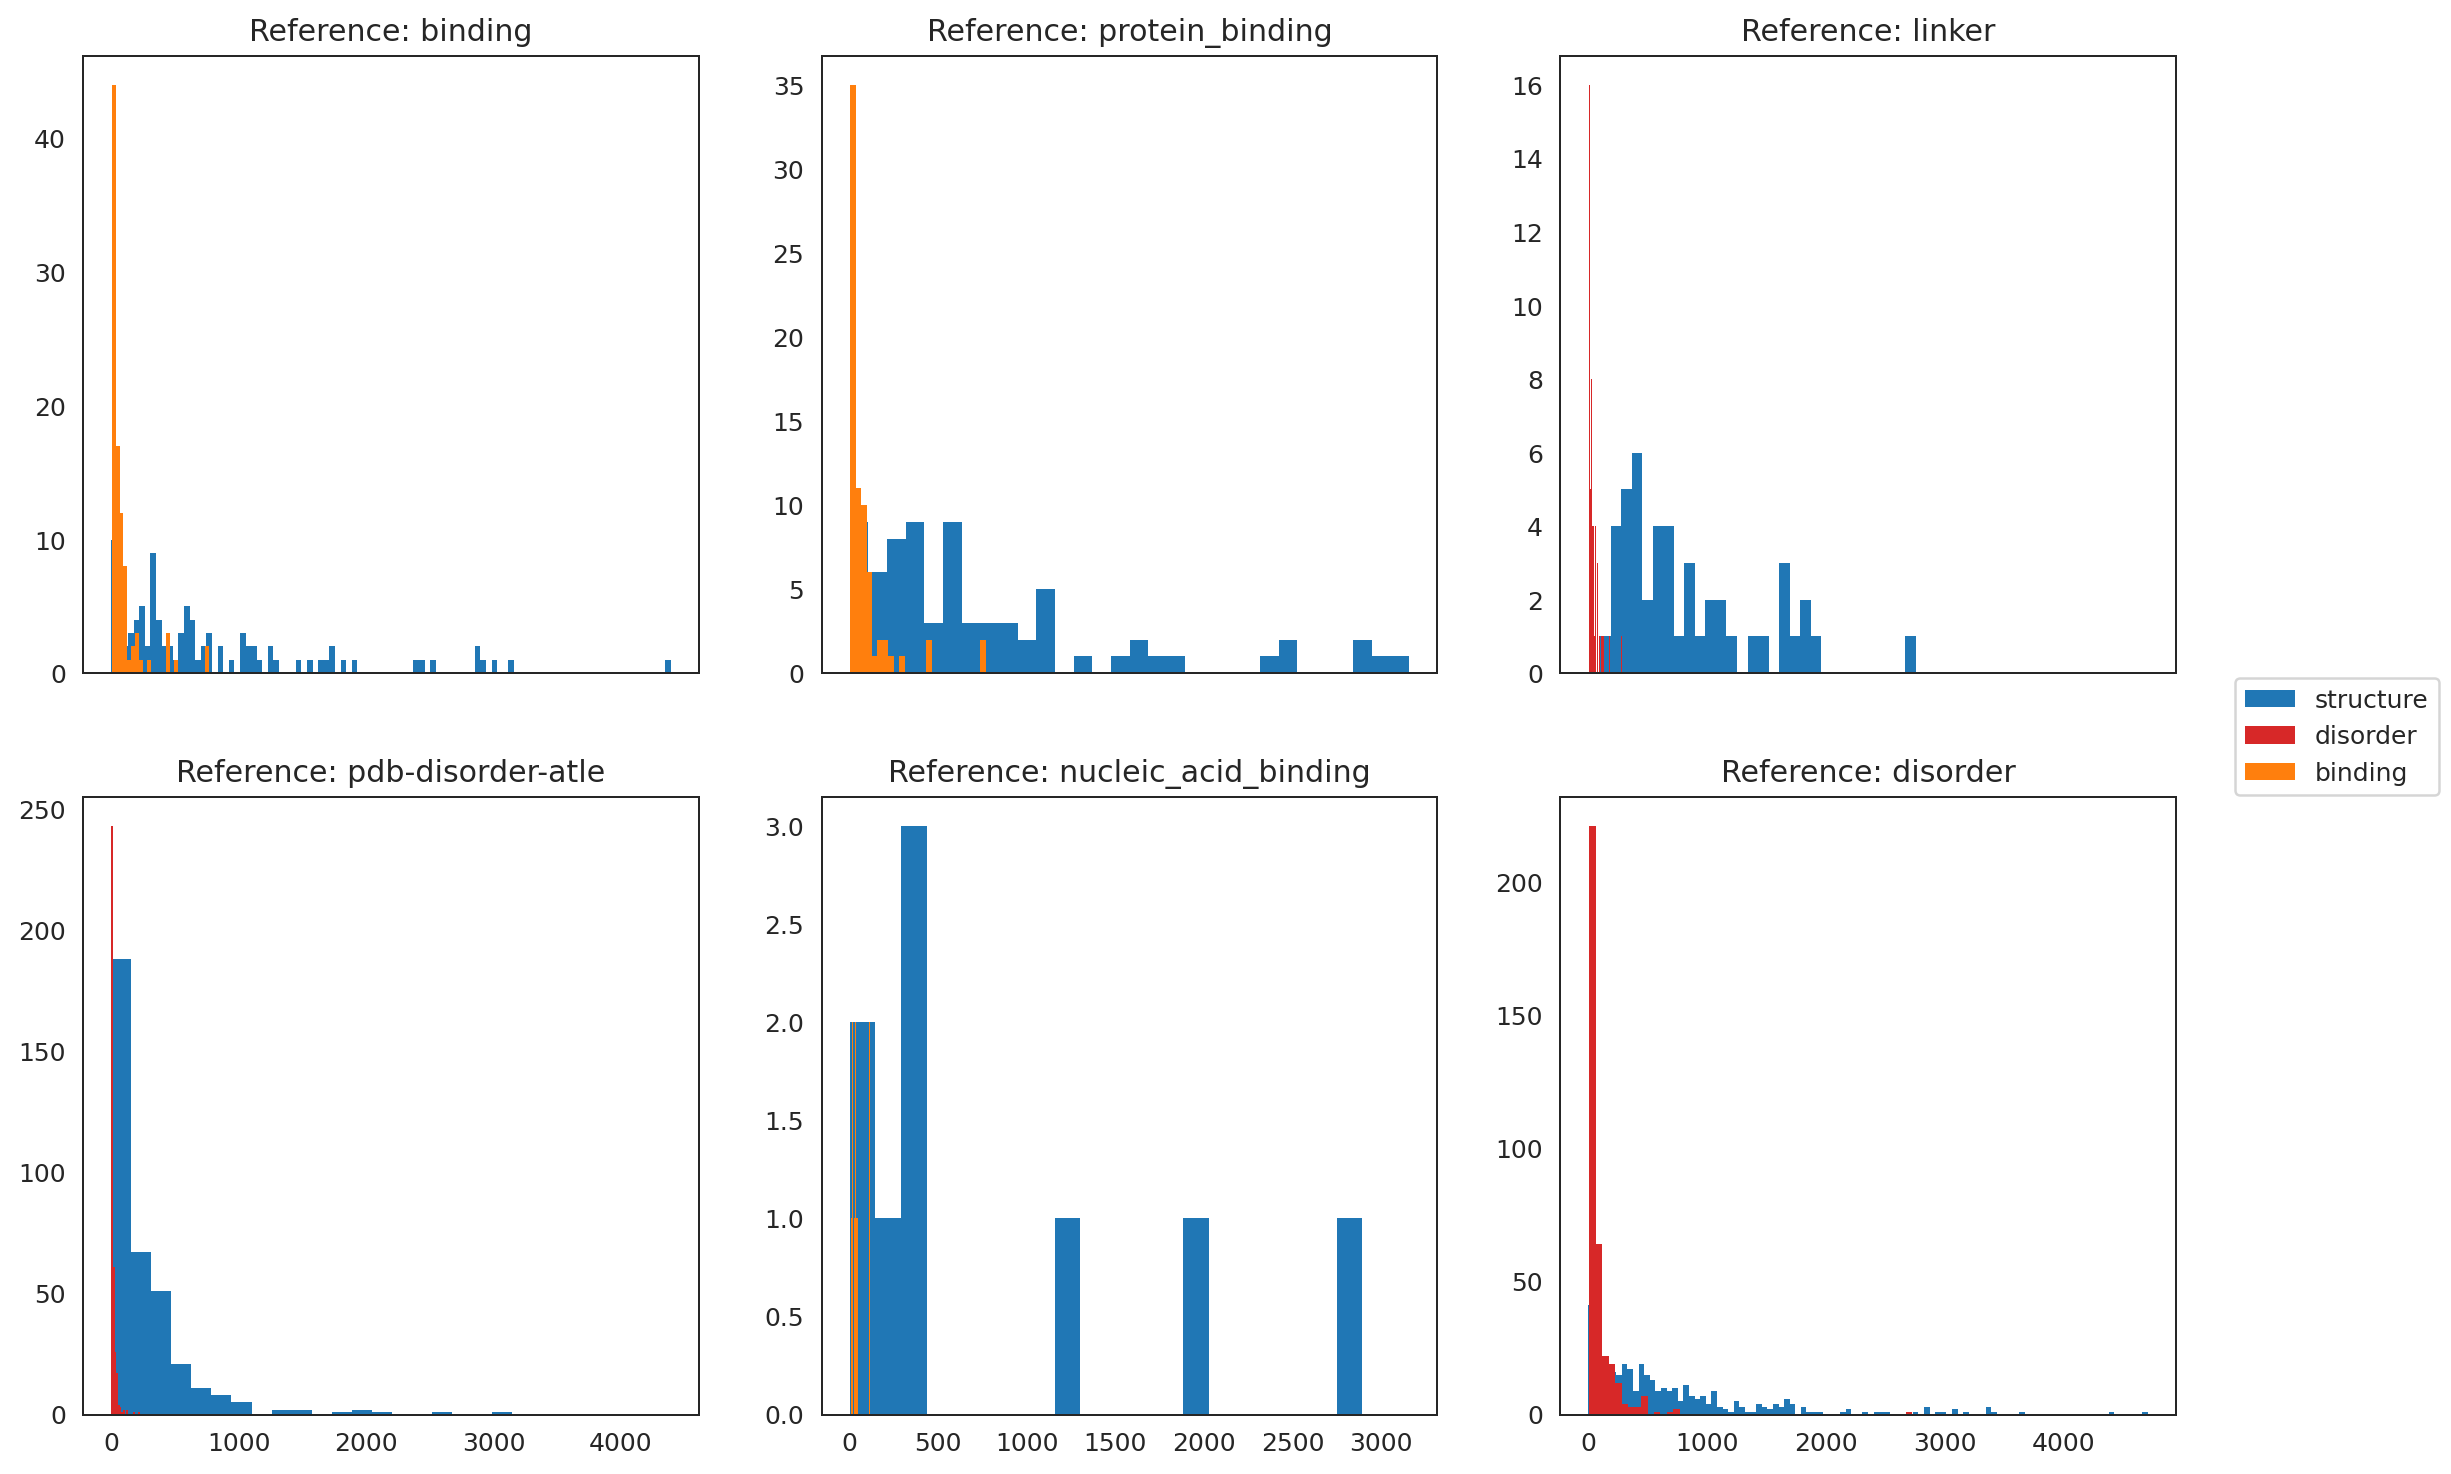

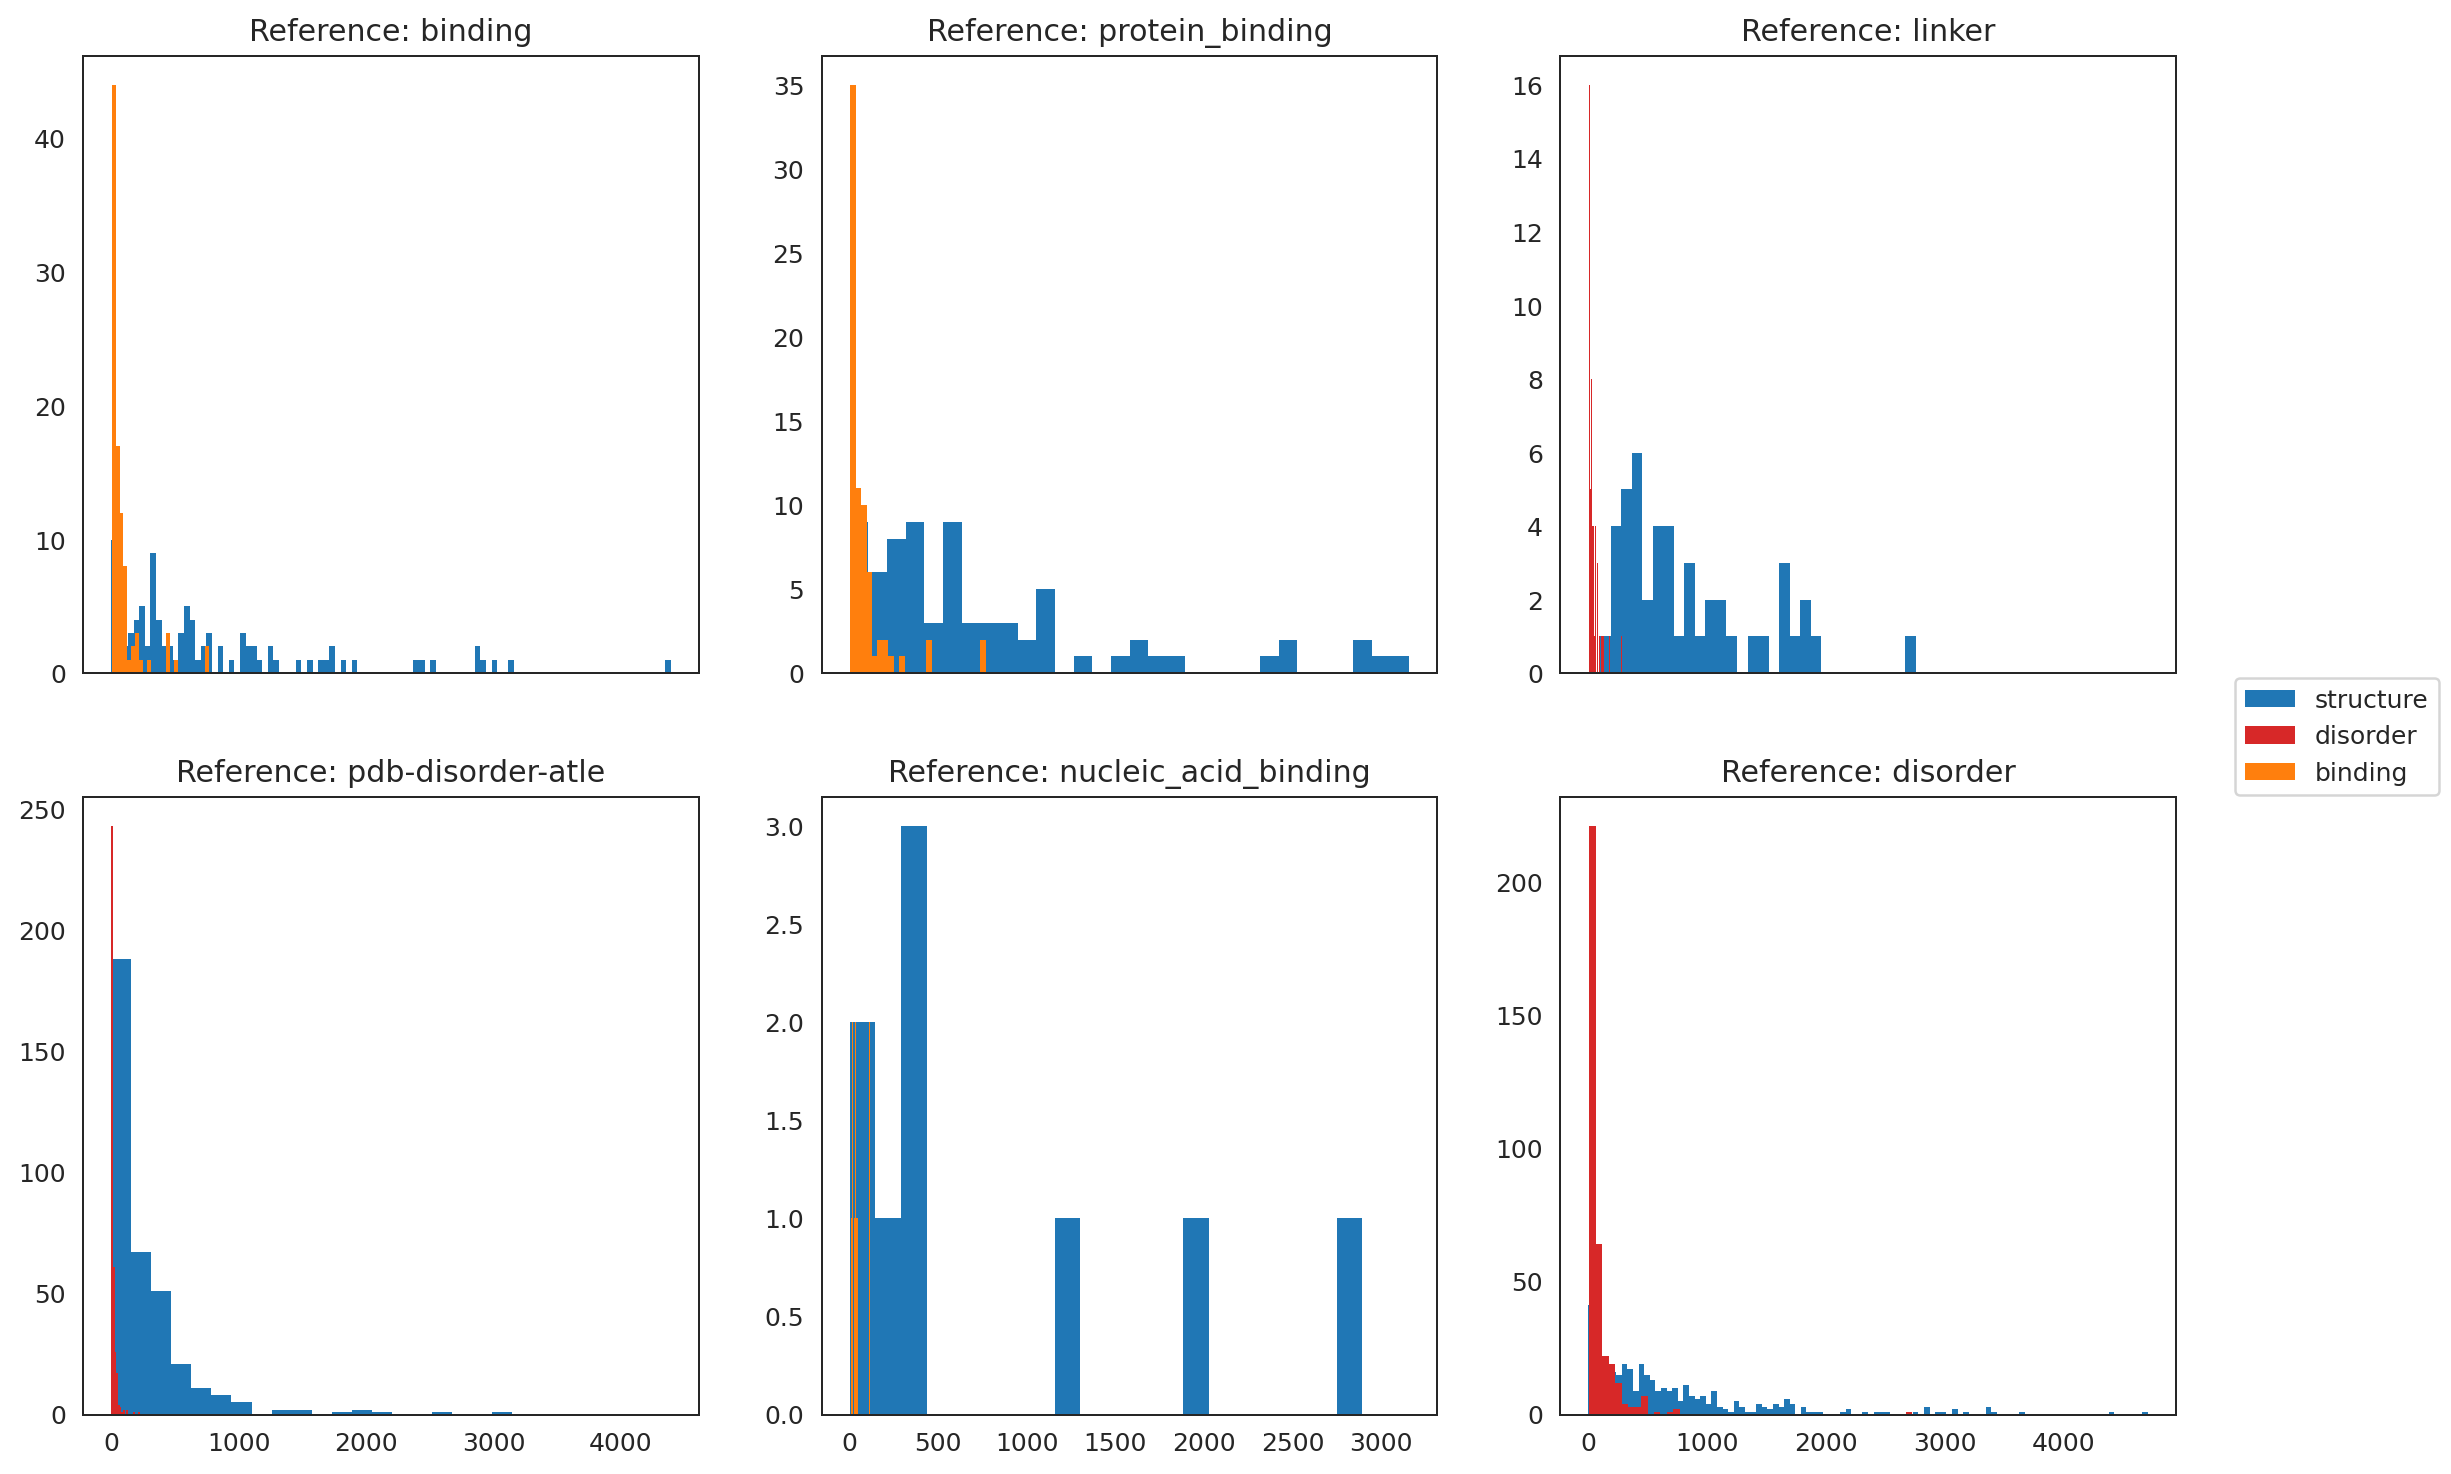

In [11]:
plot_grid = 2, 3
fig, axes = plt.subplots(*plot_grid, sharex='col', figsize=(15, 10))
n = 0
# print(axes)
positive_bins = [
    [25, 25, 30],
    [17, 17, 50]
]
negative_bins = [
    [100, 30, 30],
    [20, 20, 100]
]
negative_plot = positive_plot = binding_plot = None
for i in range(plot_grid[0]):
    for j in range(plot_grid[1]):
        ref_df = df[df.ref == ref_list[n]]
        negative_plot = axes[i][j].hist(ref_df['negative'], bins=negative_bins[i][j], lw=0, color='#2077B5')
        positive_plot = axes[i][j].hist(ref_df[ref_df.type == 'disorder']['positive'], bins=positive_bins[i][j], lw=0, color='#D72828')
        binding_plot = axes[i][j].hist(ref_df[ref_df.type == 'binding']['positive'], bins=positive_bins[i][j], lw=0, color='#FF7F0D')
        plt.setp(axes[i][j], title=f'Reference: {ref_list[n]}')
        n += 1
fig.legend(labels=['structure','disorder', 'binding'], loc='center right')
fig.get_figure()

## Detection method of fully disordered proteins
### Load Evidence Ontology


In [12]:
# Download obo file from evidenceontology
eco_path = Path(json_dir / 'eco.obo')
!wget -O $eco_path https://raw.githubusercontent.com/evidenceontology/evidenceontology/cec01fd302c009e94e1f30b3bd995bb8646342da/eco.obo

--2022-08-16 15:50:34--  https://raw.githubusercontent.com/evidenceontology/evidenceontology/cec01fd302c009e94e1f30b3bd995bb8646342da/eco.obo
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1217867 (1.2M) [text/plain]
Saving to: ‘/home/adel/projects/caid2-reference/data/json/eco.obo’

/home/adel/projects 100%[===================>]   1.16M  --.-KB/s    in 0.03s   

2022-08-16 15:50:35 (33.6 MB/s) - ‘/home/adel/projects/caid2-reference/data/json/eco.obo’ saved [1217867/1217867]



In [13]:
from obonet import read_obo
graph = read_obo(eco_path)
leaves = [x for x in graph.nodes() if graph.in_degree(x) == 1 ]

df_ont = pd.DataFrame([[node[0], node[1].get('def')] for node in graph.nodes(data=True) if  node[0] in leaves], columns=['term', 'def'])
df_ont = df_ont[pd.notnull(df_ont['def'])]


In [14]:
ec_dict = {
    node[0]: [node[1].get('name'), 0] for node in graph.nodes(data=True) if node[1]
}

In [15]:
import json
region_count = 0
with open(disprot_dir / 'entries_private_caid2.json', 'r') as f:
    private_entries = json.load(f)
    for entry in private_entries['data']:
        disprot_id = entry['disprot_id']
        for region in entry['regions']:
            region_count += 1
            ec_dict[region['ec_id']][1] += 1

In [16]:
df = pd.DataFrame.from_dict(ec_dict, orient='index', columns=['definition', 'count'])

In [17]:
df = df.sort_values('count', ascending=False).head(20).sort_values('count')

Text(0.5, 1.0, 'regions')

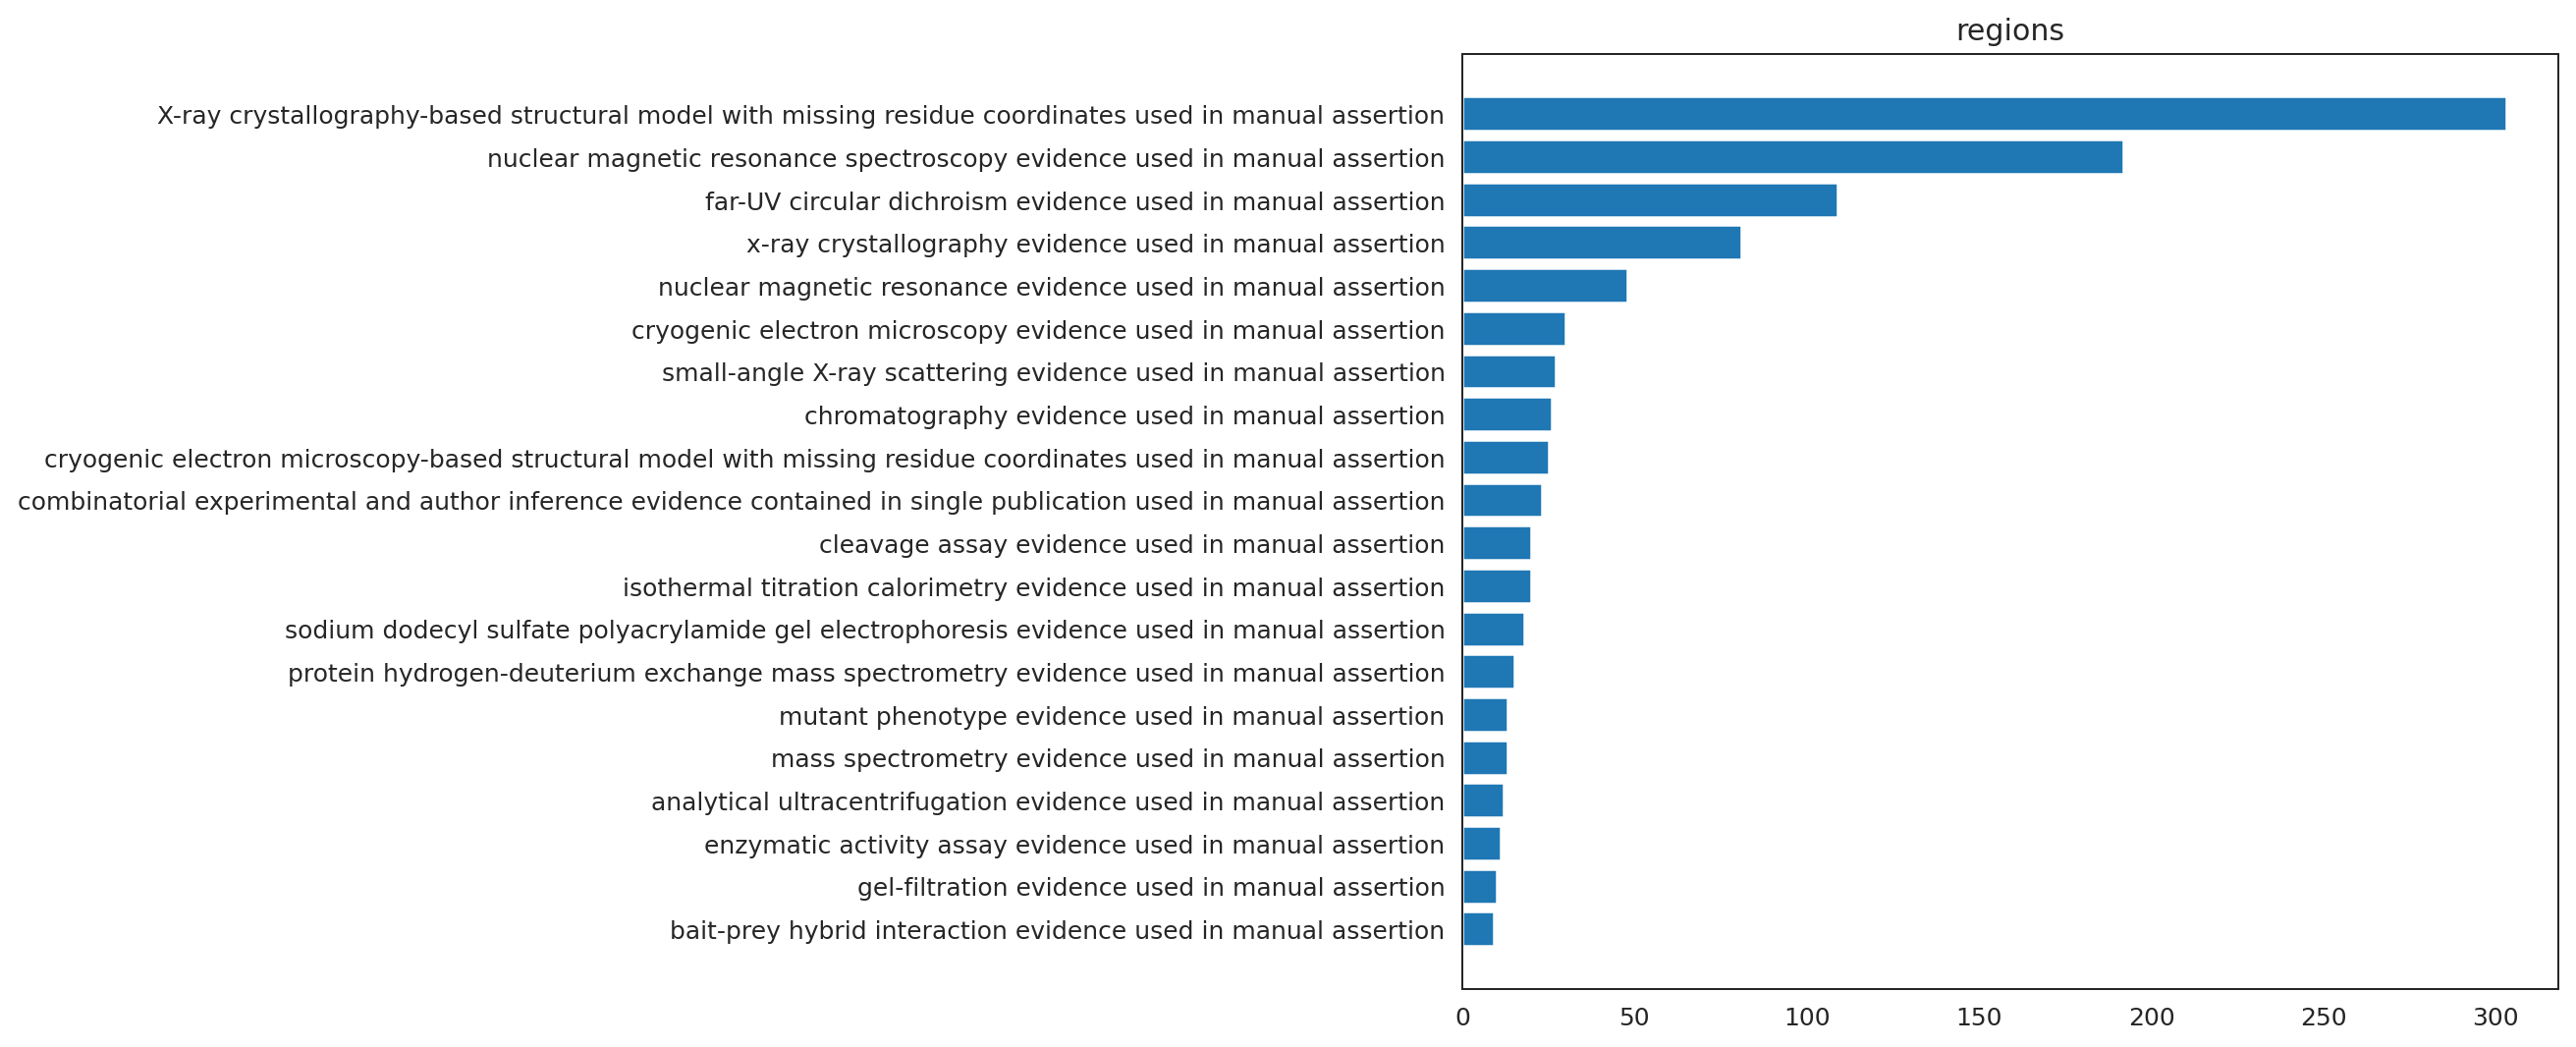

In [18]:
fig, ax = plt.subplots(figsize=(8, 7))

fig.dpi = 180
ax.barh(df['definition'], df['count'])
ax.set_title('regions')
# fig.title('regions')
# fig.get_figure()

## Fraction of disordered residues in fully disordered proteins

Distribution of the fraction of disordered residues for the proteins with at least 95% of disordered
residues in the DisProt dataset (n= 41 proteins) and in their predicted fraction of disordered residues for
each method. Methods are sorted by their median. Boxplots are defined as follows: the middle value of
the dataset is the median (Q2/50th Percentile). The box boundaries are the 1st quartile (Q1/25th
Percentile) and 3rd quartile (Q3/75th Percentile) respectively; Maximum is Q3 + 1.5*(Q3-Q1) and
Minimum is Q1 -1.5*(Q3-Q1)

In [19]:
import os


class Prediction:
    def __init__(self, file_path: Path):
        self.file = open(file_path, 'r')
        self.name = file_path.stem

    def __del__(self):
        self.file.close()

    def strip_split(self, string: str) -> list:
        """
        remove newlines and split by tabs, raise an error for unexpected number of elements from split

        :param string: string to modify
        :return: splitted string
        """
        splitted = string.strip('\n').rsplit('\t')
        return splitted


    def to_dict(self, threshold=0.5):
        # pred = {(self.name, 'states'): {}, (self.name, 'scores'): {}}
        pred = {}

        faiter = (x[1] for x in groupby(self.file, lambda line: line[0] == ">"))
        for acc in faiter:
            acc = next(acc).strip()[1:]
            # acc = acc.split('\t')[0]
            body = next(faiter)

            positions, _, scores, states = zip(*map(self.strip_split, body))
            # check truth-ish of a value instead of that of its container since zip(*map(strip_split, body))
            # returns list of empty strings when values are missing
            if states[0]:
                states = np.array(states, dtype=np.float64)
                # when scores are missing, use states as scores
                scores = np.array(scores, dtype=np.float64) if scores[0] else states
            else:
                if scores[0]:
                    scores = np.array(scores, dtype=np.float64)
                    # when states are missing, apply threshold to scores to generate states
                    # if threshold is not passed, default to 0.5
                    states = np.greater_equal(scores, threshold).astype(np.float64)
                else:
                    continue

            # reshape so that casting to pd.DataFrame is very quick
            # for i, (st, sc), in enumerate(zip(states, scores)):
            pred[acc] = list(states)
        self.file.seek(0)
        return pred

    def get_seq(self, name:str):
        print(f'filename {self.name}, seq: {name}')
        name = f'>{name}' if not name.startswith('>') else name
        for line in self.file:
            if line.startswith('>') and name in line:
                line = next(self.file).strip('\n')
                while not line.startswith('>') and line != '':
                    line_list = list(filter(lambda x: x != '', line.split('\t')))
                    try:
                        if len(line_list) < 4:
                            *_, amin, score = line_list
                            score =  float(score)
                            yield amin, score, 1.0 if score > 0.5 else 0.0
                        else:
                            _, amin, score, state = line_list
                            yield amin, float(score), float(state)
                    except Exception as e:
                        print(f'pred: {self.name}, acc:{name}, line: "{line}", line_list: {line_list}')
                        raise e
                    line = self.file.readline().strip('\n')
        self.file.seek(0)


filename AlphaFold-dis25, seq: DP02909
1	M	0.699	

2	S	0.706	

3	L	0.692	

4	F	0.703	

5	D	0.707	

6	L	0.713	

7	F	0.733	

8	R	0.746	

9	G	0.742	

10	F	0.750	

11	F	0.751	

12	G	0.762	

13	F	0.783	

14	P	0.778	

15	G	0.800	

16	P	0.812	

17	R	0.818	

18	S	0.826	

19	H	0.826	

20	R	0.836	

21	D	0.850	

22	P	0.847	

23	F	0.844	

24	F	0.849	

25	G	0.852	

26	G	0.853	

27	M	0.852	

28	T	0.871	

29	R	0.872	

30	D	0.870	

31	E	0.870	

32	D	0.870	

33	D	0.866	

34	D	0.879	

35	E	0.883	

36	E	0.888	

37	E	0.877	

38	E	0.879	

39	E	0.882	

40	E	0.882	

41	G	0.875	

42	G	0.868	

43	S	0.874	

44	W	0.883	

45	G	0.879	

46	R	0.878	

47	G	0.887	

48	N	0.894	

49	P	0.903	

50	R	0.901	

51	F	0.912	

52	H	0.905	

53	S	0.910	

54	P	0.904	

55	Q	0.900	

56	H	0.891	

57	P	0.891	

58	P	0.896	

59	E	0.884	

60	E	0.881	

61	F	0.870	

62	G	0.878	

63	F	0.866	

64	G	0.860	

65	F	0.859	

66	S	0.863	

67	F	0.867	

68	S	0.844	

69	P	0.828	

70	G	0.831	

71	G	0.817	

72	G	0.800	

73	I	0.777	

74	R	0.761	

75	F	0.7

IndexError: list index out of range

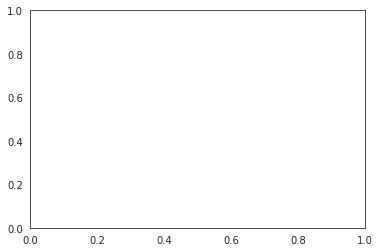

In [60]:
# for prediction in predictions_dir.glob('*'):

prediction = predictions_dir / 'VSL2.caid'

    # pred = Prediction(prediction).to_dict()
ref = Reference(reference_dir / 'binding.fasta')
fig ,ax = plt.subplots()

plot_data = {}



# for reference in reference_dir.glob('*'):
#     ref = Reference(reference)
for prediction in predictions_dir.glob('*'):
    pred = Prediction(prediction)
    ratios = []
    total = correct = 0
    for acc, seq, states in ref.vectorized_format():
        if states.count('0') == 0 or (states.count('1') / states.count('0')) > 0.95:
            # convert states to flaot
            ref_state_list = [*states.replace('-', '0')]
            ref_state_list = [float(state) for state in ref_state_list]
            pred_seq = pred.get_seq(acc)
            if pred_seq is not None:
                pred_state_list = [state for *_, state in pred_seq]

                for i in range(len(ref_state_list)):
                    if ref_state_list[i] == 1.0:
                        total += 1
                        if ref_state_list[i] == pred_state_list[i]:
                            correct += 1
                ratios.append(correct / total)
            else:
                ratios.append(None)
    plot_data[pred.name] = ratios

# for pred_name in plot_data:
#     print(f'{pred_name}: {plot_data[pred_name]}')

df = pd.DataFrame(plot_data)
# ax.boxplot(df, labels=df.columns)



# print(ratios)

In [41]:
def compute_ratios(ref:Reference, pred:Prediction):
    ratios = []
    total = correct = 0
    for acc, seq, states in ref.vectorized_format():
        if states.count('0') == 0 or (states.count('1') / states.count('0')) > 0.95:
            # convert states to flaot
            ref_state_list = [*states.replace('-', '0')]
            ref_state_list = [float(state) for state in ref_state_list]
            pred_seq = pred.get_seq(acc)
            if pred_seq is not None:
                pred_state_list = [state for *_, state in pred_seq]

                for i in range(len(pred_state_list)):
                    if ref_state_list[i] == 1.0:
                        total += 1
                        if ref_state_list[i] == pred_state_list[i]:
                            correct += 1
                ratios.append(correct / total)
            else:
                ratios.append(None)
    return pred.name, ratios

refs = [Reference(reference_dir / 'disorder.fasta') for file in predictions_dir.glob('*')]
preds = [Prediction(file) for file in predictions_dir.glob('*')]
inputs = zip(refs, preds)

# for input in inputs:
#     print(input)

from multiprocessing.dummy import Pool as ThreadPool
with ThreadPool(4) as p:
    ratios_list = p.starmap(compute_ratios, inputs)
    # print(ratios_list)

filename AlphaFold-dis25, seq: DP02342
filename AlphaFold-dis, seq: DP02342
filename AUCpred-profile, seq: DP02342
filename ANCHOR2, seq: DP02342
filename AlphaFold-dis, seq: DP02348
filename ANCHOR2, seq: DP02348
filename AUCpred-profile, seq: DP02348
filename AUCpred-profile, seq: DP02544
filename AlphaFold-dis25, seq: DP02348
filename ANCHOR2, seq: DP02544
filename AlphaFold-dis25, seq: DP02544
filename AlphaFold-dis, seq: DP02544
filename AlphaFold-dis, seq: DP02558
filename ANCHOR2, seq: DP02558
filename AUCpred-profile, seq: DP02558
filename AlphaFold-dis25, seq: DP02558
filename AlphaFold-dis, seq: DP02595
filename AUCpred-profile, seq: DP02595
filename AlphaFold-dis, seq: DP02849
filename ANCHOR2, seq: DP02595
filename AlphaFold-dis, seq: DP02904
filename AUCpred-profile, seq: DP02849
filename AlphaFold-dis, seq: DP02909
filename AlphaFold-dis, seq: DP02914
filename AlphaFold-dis, seq: DP02948
filename AlphaFold-dis, seq: DP02972
filename AlphaFold-dis25, seq: DP02595
filename 

In [40]:
ratios_list

[('AlphaFold-dis25',
  [0.9283154121863799,
   0.9485861182519281,
   0.8726169844020797,
   0.8726169844020797,
   0.8726169844020797,
   0.8765743073047859,
   0.9129146919431279,
   0.9157593123209169,
   0.922875131164743,
   0.9206812652068127,
   0.9154929577464789]),
 ('IDP-Fusion',
  [1.0, 1.0, 0.97, 0.9560551865099642, 0.959395656279509, 0.9382443758270842]),
 ('ENSHROUD-protein', [0.9126984126984127]),
 ('PredIDR-short',
  [0.23809523809523808,
   0.6862745098039216,
   0.6862745098039216,
   0.3875968992248062,
   0.3875968992248062,
   0.3875968992248062,
   0.3875968992248062,
   0.3875968992248062,
   0.3875968992248062,
   0.30177514792899407,
   0.3103448275862069,
   0.3103448275862069,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.32432432432432434,
   0.38524590163934425,
   0.38524590163934425,
   0.38524590163934425,
   0.38524590163934425,

In [43]:
ratios_dict = {name: ratios for name, ratios in ratios_list}
ratios_dict

{'AlphaFold-dis25': [1.0,
  0.8925233644859814,
  0.7169625246548323,
  0.8,
  0.8341040462427746,
  0.8440217391304348,
  0.8607472100921882,
  0.8688034188034188,
  0.8746938775510205,
  0.876706827309237,
  0.888848660391021,
  0.8769492486532464,
  0.872899926953981,
  0.872899926953981,
  0.872899926953981,
  0.8783216783216783,
  0.88022028453419,
  0.8960573476702509,
  0.8960573476702509,
  0.9054176481246603,
  0.9071504802561366,
  0.9071504802561366,
  0.8963963963963963,
  0.8973723351512147,
  0.8973723351512147,
  0.8941027266962587,
  0.8941027266962587,
  0.8959501557632399,
  0.8959501557632399,
  0.8975774302361239,
  0.8975774302361239,
  0.9008019008019008,
  0.9031182015953589,
  0.8828375925150118,
  0.8641774891774892,
  0.864739424479512,
  0.8651863600317209,
  0.8691972300589895,
  0.8712771327612318,
  0.8765880217785844,
  0.8765880217785844,
  0.8765880217785844,
  0.8765880217785844,
  0.8795180722891566,
  0.8693525850023288,
  0.8712591756070017,
  0.871

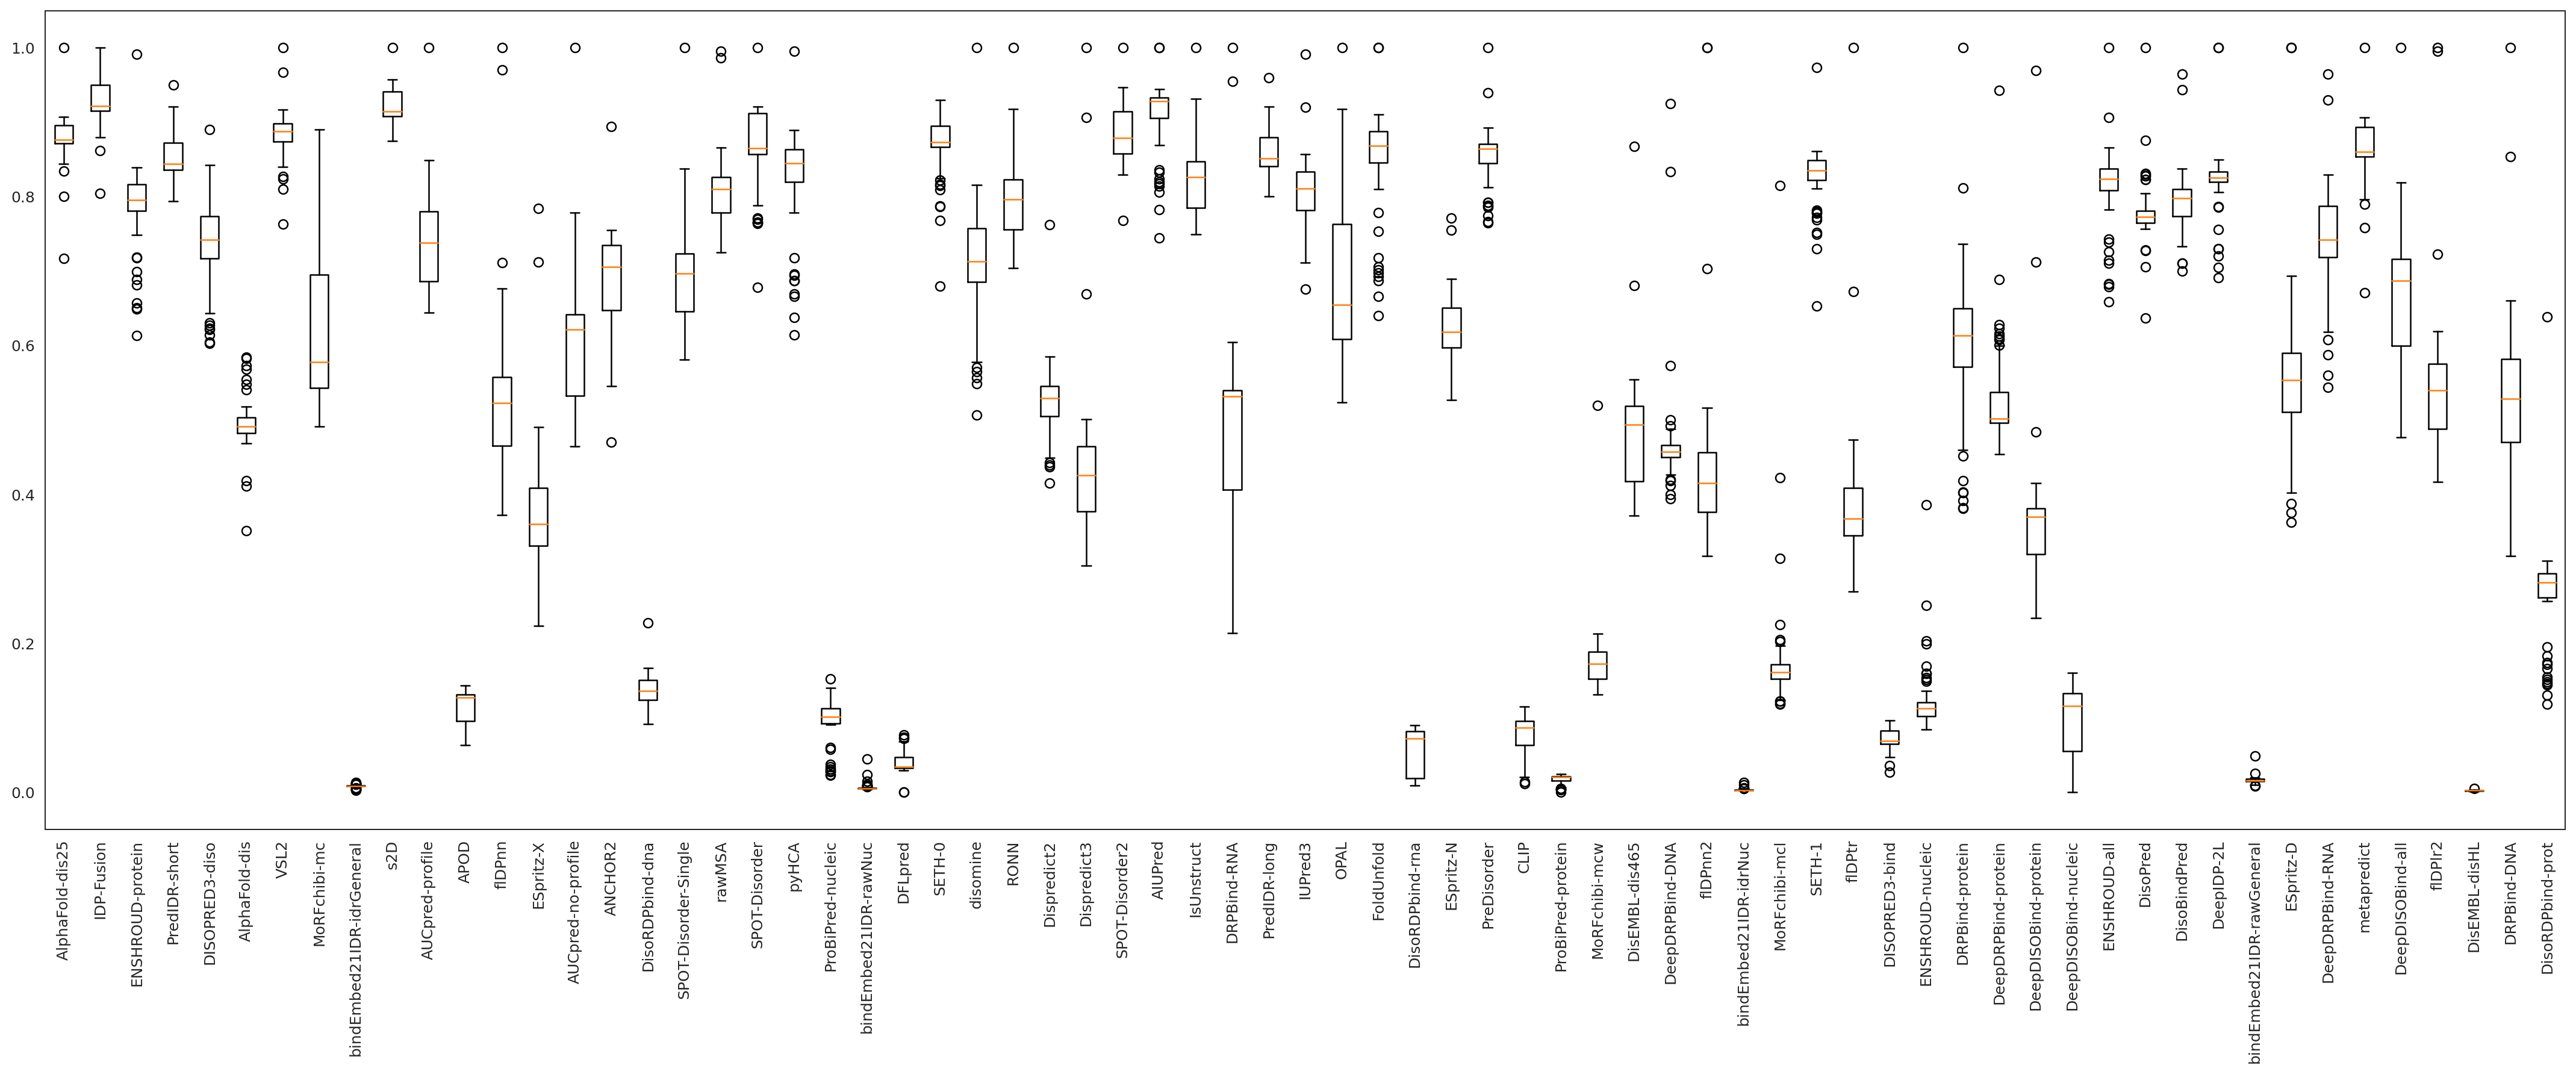

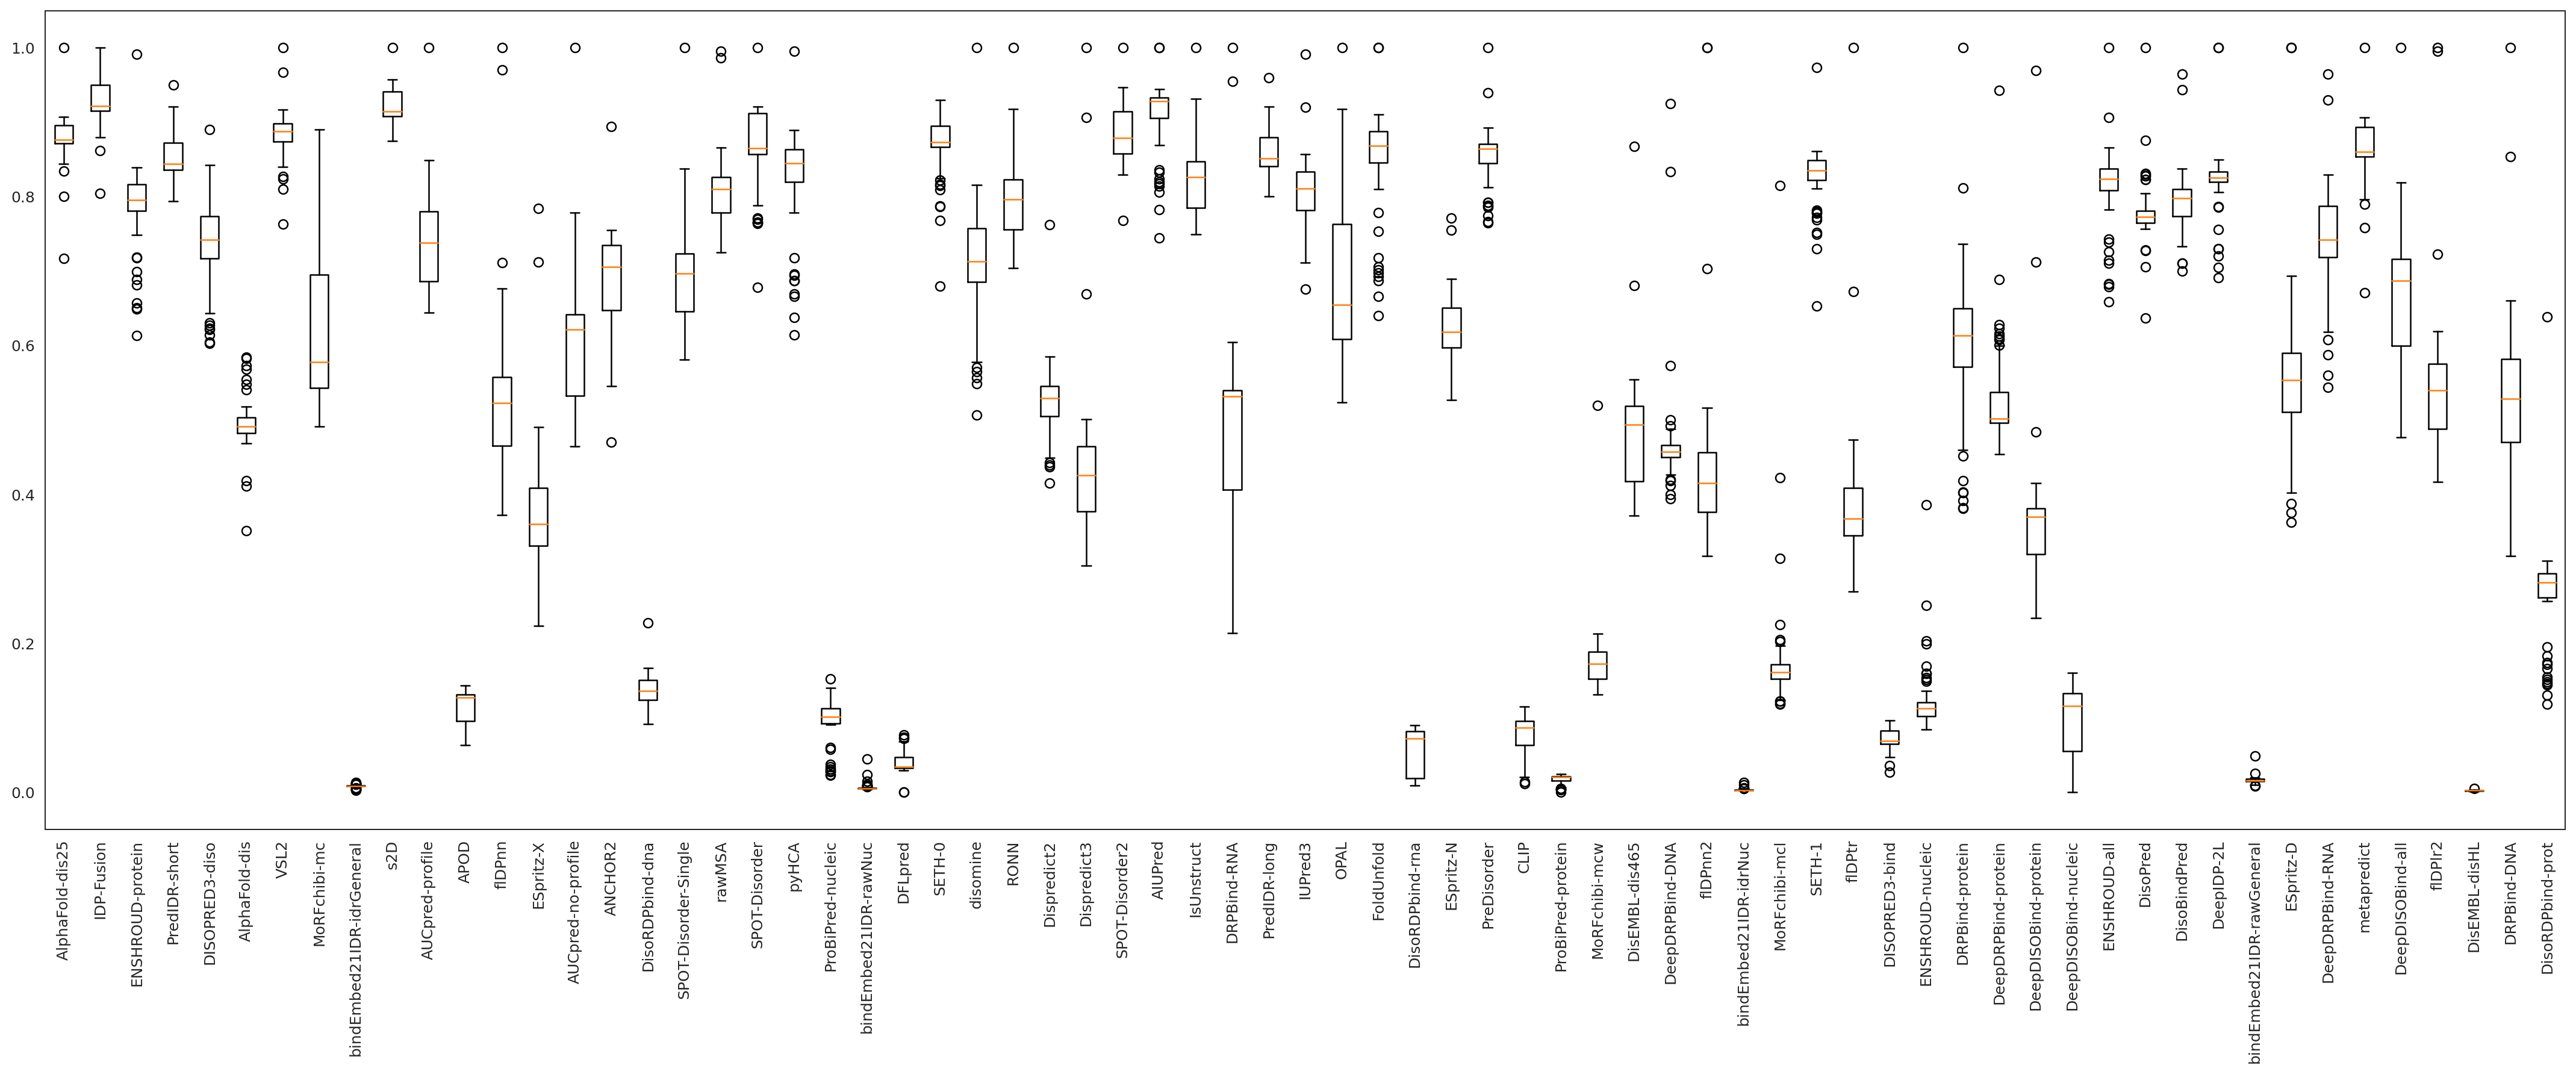

In [60]:
# prepping the data
df = pd.DataFrame(ratios_dict, columns=list(ratios_dict.keys()))

fig, ax = plt.subplots(figsize=(30, 10))
fig.dpi = 180
plt.setp(fig, facecolor='#fff')
ax.boxplot(df, labels=list(ratios_dict.keys()), )
plt.xticks(rotation=90)
fig.get_figure()